# Proyecto – Detección de Comunidades

Esta guía proporciona una estructura para el estudio del análisis de comunidades en redes.


* Asignatura: Base de datos 3
* Profesor: Ana Aguilera Faraco
* Ayudante: Fernanda Fuentes
* Fecha: 7 de noviembre del 2025

**Integrantes**


* Dante Chavez  dante.chavez@estudiantes.uv.cl
* Nikolas Lagos  nikolas.lagos@estudiantes.uv.cl
* Franko Moraga  franko.moraga@estudiantes.uv.cl
* Miguel Espinoza  miguel.espinoza@estudiantes.uv.cl

**Presentacion**

Este trabajo tiene como objetivo introducir y demostrar el concepto de detección de comunidades en redes complejas, un tema central en la minería de grafos y la ciencia de datos. A través de una explicación teórica y una implementación práctica en Python, se busca mostrar cómo identificar grupos de nodos altamente conectados dentro de una red, revelando patrones ocultos de relación.

**Objetivo General**

Comprender y aplicar técnicas de detección de comunidades en redes, evaluando los resultados según la estructura del grafo.

**Objetivos Específicos**

* Introducir conceptos clave sobre redes y grafos en ciencia de datos.
* Explicar la utilidad de detectar comunidades y sus aplicaciones.
* Implementar algoritmos de detección en un dataset de red.
* Visualizar y analizar los resultados mediante métricas y gráficos.

**Conceptos Clave**

* **Red:** Conjunto de elementos conectados entre sí. En ciencia de datos, se usa para modelar relaciones entre entidades (personas, productos, genes, etc.).
* Grafo: Representación matemática de una red, formada por nodos (entidades) y aristas (relaciones).
* Nodo: Elemento individual dentro de una red (por ejemplo, un usuario en una red social).
* Arista: Conexión entre dos nodos, que puede ser dirigida o no, y tener peso.
* **Detección de comunidades:** Conjunto de técnicas no supervisadas utilizadas para encontrar grupos de nodos altamente interconectados. Tambien es el proceso de identificar grupos de nodos con alta conectividad interna y ayuda a descubrir estructuras ocultas en redes complejas.

* Modularidad: Métrica que evalúa la calidad de una partición en comunidades. Cuanto mayor sea, mejor definida está la comunidad.
* Algoritmo Louvain: Método eficiente que agrupa nodos maximizando la modularidad.
* Girvan–Newman: Algoritmo que elimina aristas con alta intermediación para dividir la red.
* Label Propagation: Técnica rápida que asigna etiquetas a nodos y las propaga hasta estabilizarse.

**Introducción**

Este trabajo busca aplicar técnicas de **detección de comunidades en redes complejas**, utilizando un enfoque práctico a partir de un dataset real.  
Para ello, se emplea un conjunto de datos del repositorio **[SNAP (Stanford Large Network Dataset Collection)](https://snap.stanford.edu/data/wiki-topcats.html)**, conocido por reunir redes utilizadas en investigación y análisis de grafos.

El dataset elegido es **“Wikipedia network of top categories”**, que representa una red de hipervínculos entre artículos de Wikipedia recopilada en septiembre de 2011.  
Cada nodo corresponde a una página, y cada enlace indica una relación entre ellas. Además, cada artículo pertenece a una o más categorías, las cuales se pueden considerar como **comunidades de referencia** (*ground-truth communities*), ya que reflejan agrupaciones reales dentro del sitio.

La elección de este dataset se debe a principalmente:  
- **Tamaño y complejidad:** con más de 1,7 millones de nodos y 28 millones de enlaces, permite analizar un sistema grande y realista.  
- **Categorías como comunidades:** las categorías temáticas sirven como base para validar los resultados de los algoritmos de detección.  
- **Interés y aplicabilidad:** el estudio de Wikipedia permite entender cómo se relacionan los temas y cómo se forman comunidades naturales dentro del conocimiento en línea.

-Este cuaderno busca demostrar cómo los métodos de detección de comunidades pueden revelar la estructura interna de una red, utilizando un caso real y relevante como el de Wikipedia.

-Yin, H., Benson, A. R., Leskovec, J., & Gleich, D. F. (2017). Local higher-order graph clustering. Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. Recuperado de https://snap.stanford.edu/data/ [snap.stanford.edu]


**Estructura del Estudio**

1. Descripción y Preparación del Dataset
2. Análisis de Estructura de Red
3. Métodos de Detección de Comunidades
4. Visualización de Comunidades
5. Métricas y Evaluación de Comunidades
6. Análisis Temporal de Comunidades

**Librerias usadas:**

In [3]:
import pandas as pd  # manejo y análisis de datos tabulares (DataFrame)
import numpy as np  # cálculo numérico y arrays eficientes
import networkx as nx  # construcción y análisis de grafos/redes
import matplotlib.pyplot as plt  # visualización (plots, histogramas, visualización de grafos)
import random  # muestreo aleatorio y funciones de aleatoriedad
import os  # interacción con el sistema de archivos (comprobación, tamaño, rutas)
import math  # funciones matemáticas básicas (log, sqrt, etc.)
import statistics  # estadísticas básicas (mean, median, stdev)
from collections import Counter, defaultdict  # Counter: conteos; defaultdict: diccionarios con valor por defecto

# 1. Descripción y Preparación del Dataset

En esta sección se realizará la carga, exploración y preparación inicial del dataset seleccionado.  

El objetivo es **asegurar la calidad y consistencia de los datos** antes de aplicar algoritmos de detección de comunidades.  

Para ello se trabajará con el conjunto **“Wikipedia network of top categories”**, obtenido del repositorio [SNAP](https://snap.stanford.edu/data/), el cual representa la red de hipervínculos entre páginas de Wikipedia.

**1.1 Carga del Dataset**

 
Primero se importan las librerías necesarias y se carga el dataset desde el archivo `wiki-topcats.txt`, el cual contiene las conexiones (aristas) entre páginas de Wikipedia (nodos).  
Esta etapa permite verificar que los datos se leen correctamente y obtener una visión general del tamaño de la red.

  
La carga inicial y la revisión básica permiten detectar posibles errores de formato, valores faltantes o problemas de codificación que puedan afectar los análisis posteriores.


**1.2 Análisis Inicial de la Estructura del Grafo**

 
A partir del dataset cargado, se construye un grafo no dirigido usando *NetworkX* y se calculan métricas básicas como:
- Número de nodos y aristas.  
- Densidad de la red (qué tan conectada está).  
- Distribución de grados (cantidad de enlaces por nodo).


Estas métricas permiten entender el tamaño, complejidad y conectividad del grafo.  
Dado que el dataset es grande, se trabaja con una versión reducida para fines demostrativos, manteniendo sus propiedades estructurales.

Dataset cargado correctamente
Total de filas (enlaces): 28,511,807
Primeras filas del dataset:


,source,target
0,0,10772
1,1,2
2,1,170193
3,1,598775
4,2,1


=== Análisis de la Red ===

Número total de enlaces (conexiones entre páginas): 28,511,807
Número total de nodos (páginas únicas de Wikipedia): 1,791,489

=== Métricas de la Red ===
Tipo de red: No dirigida (No dirigida significa que los enlaces son bidireccionales)
Densidad: 0.000016 (Porcentaje de conexiones existentes del total posible: 0.0016%)

=== Estadísticas de Grado (número de conexiones por página) ===
Grado promedio: 28.41 enlaces por página
Grado máximo: 238342 (página más conectada)
Grado mínimo: 1 (página menos conectada)

=== Análisis de Componentes (grupos conectados) ===
Número de componentes conectados: 1
Tamaño de la componente gigante: 1,791,489 páginas
Porcentaje de páginas en la componente gigante: 100.00%
Interpretación: Todas las páginas están conectadas entre sí, formando una única red navegable.


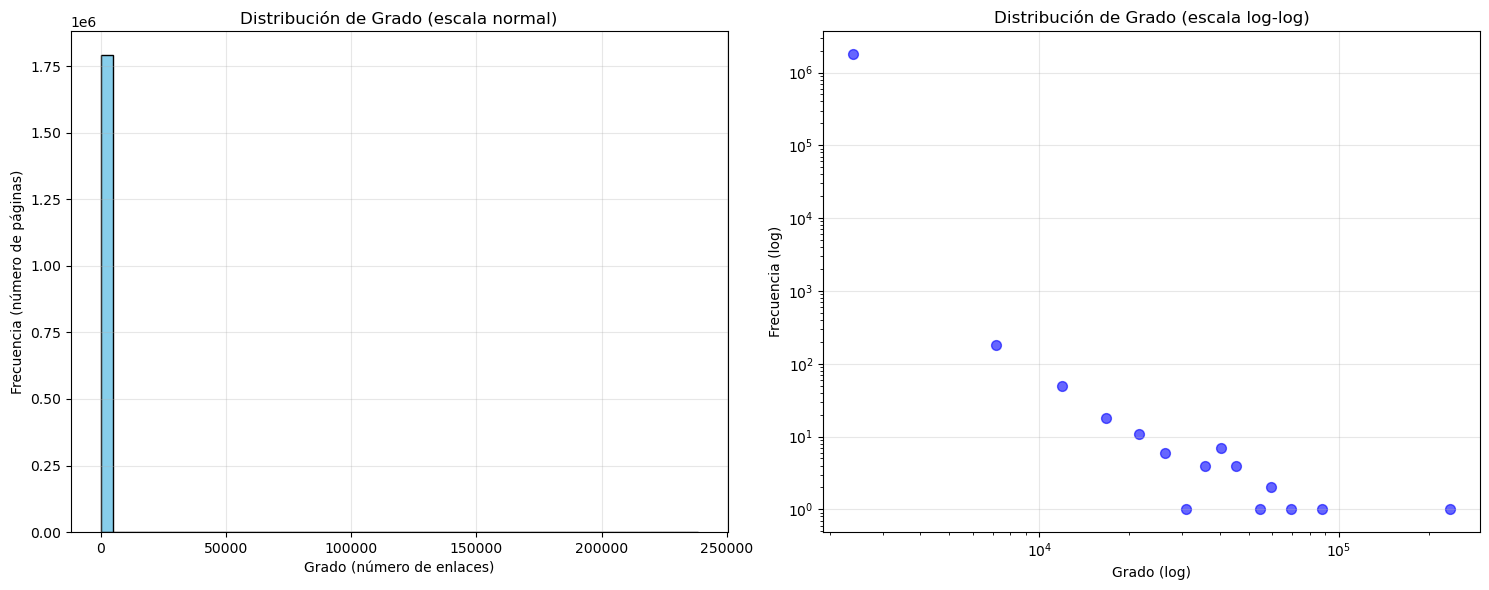

In [4]:
try:
    # Cargar el dataset
    df = pd.read_csv('wiki-topcats.txt', sep=r'\s+', header=None, names=['source', 'target'])

    print("Dataset cargado correctamente")
    print(f"Total de filas (enlaces): {len(df):,}")
    print(f"Primeras filas del dataset:")
    display(df.head())

    
    # 1. Análisis básico de la red
    print("=== Análisis de la Red ===\n")
    num_enlaces = len(df)
    num_nodos = len(set(df['source']).union(set(df['target'])))
    print(f"Número total de enlaces (conexiones entre páginas): {num_enlaces:,}")
    print(f"Número total de nodos (páginas únicas de Wikipedia): {num_nodos:,}")
    
    # 2. Análisis de conectividad y estructura
    G = nx.from_pandas_edgelist(df, 'source', 'target')
    
    # Métricas básicas
    print("\n=== Métricas de la Red ===")
    print(f"Tipo de red: {'Dirigida' if G.is_directed() else 'No dirigida'} (No dirigida significa que los enlaces son bidireccionales)")
    densidad = nx.density(G)
    print(f"Densidad: {densidad:.6f} (Porcentaje de conexiones existentes del total posible: {densidad*100:.4f}%)")
    
    # 3. Análisis de grado
    grados = dict(G.degree())
    grado_promedio = sum(grados.values()) / len(grados)
    grado_max = max(grados.values())
    grado_min = min(grados.values())
    
    print("\n=== Estadísticas de Grado (número de conexiones por página) ===")
    print(f"Grado promedio: {grado_promedio:.2f} enlaces por página")
    print(f"Grado máximo: {grado_max} (página más conectada)")
    print(f"Grado mínimo: {grado_min} (página menos conectada)")

    # Análisis de componentes y estructura
    print("\n=== Análisis de Componentes (grupos conectados) ===")
    num_componentes = nx.number_connected_components(G)
    componente_gigante = max(nx.connected_components(G), key=len)
    tam_componente_gigante = len(componente_gigante)
    porcentaje_gigante = (tam_componente_gigante/G.number_of_nodes())*100
    
    print(f"Número de componentes conectados: {num_componentes}")
    print(f"Tamaño de la componente gigante: {tam_componente_gigante:,} páginas")
    print(f"Porcentaje de páginas en la componente gigante: {porcentaje_gigante:.2f}%")
    if porcentaje_gigante == 100:
        print("Interpretación: Todas las páginas están conectadas entre sí, formando una única red navegable.")
    else:
        print(f"Interpretación: El {porcentaje_gigante:.2f}% de las páginas forman un grupo conectado principal.")
    
    # 4. Visualización de la distribución de grado
    degrees = [d for n, d in G.degree()]
    
    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histograma normal
    ax1.hist(degrees, bins=50, color='skyblue', edgecolor='black')
    ax1.set_title('Distribución de Grado (escala normal)')
    ax1.set_xlabel('Grado (número de enlaces)')
    ax1.set_ylabel('Frecuencia (número de páginas)')
    ax1.grid(True, alpha=0.3)
    
    # Histograma log-log
    # Calcular el histograma
    hist, bins = np.histogram(degrees, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2
    
    # Filtrar valores mayores que 0 para la escala log
    mask = hist > 0
    ax2.scatter(centers[mask], hist[mask], color='blue', alpha=0.6, s=50)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Distribución de Grado (escala log-log)')
    ax2.set_xlabel('Grado (log)')
    ax2.set_ylabel('Frecuencia (log)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo wiki-topcats.txt")
except Exception as e:
    print(f"Error al analizar el dataset: {str(e)}")


## 1.3 Preparación de Datos
* Limpieza de datos
  - Eliminación de duplicados
  - Manejo de valores faltantes
  - Corrección de formatos
* Normalización
  - Estandarización de identificadores
  - Conversión de tipos de datos
  - Unificación de formatos
* Validación
  - Verificación de integridad
  - Control de consistencia
  - Detección de anomalías

**Nota**: En esta sección implementaremos:
* Lectura y validación de datos
* Limpieza y normalización
* Creación de estructura de grafo
* Verificación de integridad

In [5]:
def preparar_datos(archivo):
    try:
        # 1. Carga inicial
        print("=== Cargando y limpiando datos ===")
        df = pd.read_csv(archivo, sep=r'\s+', header=None, names=['source', 'target'])
        print(f"Registros originales: {len(df)}")
        
        # 2. Limpieza básica
        # Eliminar duplicados
        df_clean = df.drop_duplicates()
        print(f"Registros después de eliminar duplicados: {len(df_clean)}")
        
        # Eliminar self-loops
        df_clean = df_clean[df_clean['source'] != df_clean['target']]
        print(f"Registros después de eliminar self-loops: {len(df_clean)}")
        
        # 3. Validación de datos
        # Verificar valores nulos o vacíos
        nulos = df_clean.isnull().sum()
        if nulos.any():
            print("\nValores nulos encontrados:")
            print(nulos)
            df_clean = df_clean.dropna()
            print(f"Registros después de eliminar nulos: {len(df_clean)}")
        
        # 4. Crear grafo limpio
        G_clean = nx.from_pandas_edgelist(df_clean, 'source', 'target')
        
        # 5. Estadísticas de limpieza
        print("\n=== Estadísticas después de limpieza ===")
        print(f"Nodos: {G_clean.number_of_nodes():,}")
        print(f"Enlaces: {G_clean.number_of_edges():,}")
        print(f"Densidad: {nx.density(G_clean):.6f}")
        
        return df_clean, G_clean
        
    except Exception as e:
        print(f"Error en la preparación de datos: {str(e)}")
        return None, None

# Descomentar la siguiente línea para ejecutar la preparación de datos
# df_limpio, G_limpio = preparar_datos('wiki-topcats.txt')

## 1.5 Muestreo Estratificado por Grado

Para trabajar eficientemente con el dataset de 1.7 millones de nodos, realizamos un **muestreo estratificado por grado** que:
- Selecciona el 5% de los nodos (aproximadamente 89,500)
- Mantiene representatividad: ALTO, MEDIO y BAJO grado
- Preserva las propiedades estadísticas principales
- Prepara datos para análisis detallados

**Estrategia:** Dividir los nodos en tres grupos según su grado (conexiones) y tomar una muestra equilibrada de cada grupo. Esto asegura que la muestra contenga nodos muy conectados, moderadamente conectados y poco conectados, reflejando la diversidad de la red original.

**Técnicas implementadas:**
- Muestreo estratificado por grado (selección de ALTO, MEDIO, BAJO grado)
- Validación de representatividad (comparar densidades)
- Control de calidad (tamaño de muestra y preservación de propiedades)

# 2. Análisis de Estructura de Red

## 2.1 Métricas Básicas (Dataset Completo)

En esta sección analizamos características rápidas del dataset completo:

* Densidad de la red
* Distribución de grado (histogramas)
* Estadísticas de grado (mínimo, máximo, promedio)
* Componentes conectados y componente gigante
* Visualización de distribuciones

**Ventaja:** Estos cálculos son rápidos incluso para 1.7 millones de nodos y dan una visión general de la estructura de la red.

In [6]:
print("\n" + "="*70)
print("MUESTREO ESTRATIFICADO DEL DATASET")
print("="*70)

if 'G' not in globals() or G is None or G.number_of_nodes() == 0:
    print('\nDataset (G) no disponible. Ejecuta primero la celda de carga de datos.')
else:
    try:
        # Configuración del muestreo
        tamano_total = G.number_of_nodes()
        porcentaje_muestra = 0.05  # 5% de los nodos
        cantidad_nodos_muestra = int(tamano_total * porcentaje_muestra)
        
        print(f'\nConfiguracion de la Muestra:')
        print(f'  Tamaño total del dataset: {tamano_total:,} nodos')
        print(f'  Porcentaje muestreado: {porcentaje_muestra*100}%')
        print(f'  Cantidad de nodos a muestrear: {cantidad_nodos_muestra:,} nodos')
        
        # Muestreo estratificado por grado
        print(f'\nMuestreo Estratificado por Grado:')
        print('  Estrategia: Seleccionar nodos de ALTO, MEDIO y BAJO grado')
        print('  Razon: Representar la diversidad de conectividad en la red\n')
        
        grados = dict(G.degree())
        nodos_ordenados = sorted(grados.items(), key=lambda x: x[1], reverse=True)
        
        # Dividir en 3 grupos: alto, medio, bajo
        tercio = cantidad_nodos_muestra // 3
        
        alto_grado = [n for n, _ in nodos_ordenados[:tercio]]
        medio_grado = [n for n, _ in nodos_ordenados[len(nodos_ordenados)//2:len(nodos_ordenados)//2 + tercio]]
        bajo_grado = [n for n, _ in nodos_ordenados[-tercio:]]
        
        nodos_muestra = alto_grado + medio_grado + bajo_grado
        G_muestra = G.subgraph(nodos_muestra).copy()
        
        print(f'Nodos de ALTO grado seleccionados: {len(alto_grado):,}')
        print(f'  Grado minimo en este grupo: {min([grados[n] for n in alto_grado]):,}')
        print(f'  Grado maximo en este grupo: {max([grados[n] for n in alto_grado]):,}')
        
        print(f'\nNodos de GRADO MEDIO seleccionados: {len(medio_grado):,}')
        print(f'  Grado minimo en este grupo: {min([grados[n] for n in medio_grado]):,}')
        print(f'  Grado maximo en este grupo: {max([grados[n] for n in medio_grado]):,}')
        
        print(f'\nNodos de BAJO grado seleccionados: {len(bajo_grado):,}')
        print(f'  Grado minimo en este grupo: {min([grados[n] for n in bajo_grado]):,}')
        print(f'  Grado maximo en este grupo: {max([grados[n] for n in bajo_grado]):,}')
        
        print(f'\nResumen de la Muestra:')
        print(f'  Total de nodos en muestra: {G_muestra.number_of_nodes():,}')
        print(f'  Total de aristas en muestra: {G_muestra.number_of_edges():,}')
        print(f'  Densidad de muestra: {nx.density(G_muestra):.6f}')
        print(f'  Densidad original: {nx.density(G):.6f}')
        
        print(f'\nG_muestra creada exitosamente y lista para analisis detallado')
        
    except Exception as e:
        print(f'\nError en muestreo: {e}')


MUESTREO ESTRATIFICADO DEL DATASET

Configuracion de la Muestra:
  Tamaño total del dataset: 1,791,489 nodos
  Porcentaje muestreado: 5.0%
  Cantidad de nodos a muestrear: 89,574 nodos

Muestreo Estratificado por Grado:
  Estrategia: Seleccionar nodos de ALTO, MEDIO y BAJO grado
  Razon: Representar la diversidad de conectividad en la red

Nodos de ALTO grado seleccionados: 29,858
  Grado minimo en este grupo: 179
  Grado maximo en este grupo: 238,342

Nodos de GRADO MEDIO seleccionados: 29,858
  Grado minimo en este grupo: 11
  Grado maximo en este grupo: 11

Nodos de BAJO grado seleccionados: 29,858
  Grado minimo en este grupo: 1
  Grado maximo en este grupo: 2

Resumen de la Muestra:
  Total de nodos en muestra: 89,574
  Total de aristas en muestra: 1,608,850
  Densidad de muestra: 0.000401
  Densidad original: 0.000016

G_muestra creada exitosamente y lista para analisis detallado


## 2.2 Análisis Detallado (Muestra)

En esta sección analizamos propiedades que requieren mayor poder computacional. Estos analisis se ejecutan en la muestra estratificada por ser muy intensivos en el dataset completo.

Propiedades a analizar:
* Coeficiente de clustering (agrupamiento local)
* Triangulos y patrones de conectividad
* Centralidades avanzadas:
  - Centralidad de grado (nodos con mas conexiones)
  - Centralidad de intermediacion (nodos que actuan como puentes)
  - Centralidad de cercania (nodos cercanos al centro de la red)
* Identificacion de nodos clave

**Nota:** Los calculos se ejecutan automaticamente cuando G_muestra este disponible (despues del muestreo estratificado).


=== MÉTRICAS BÁSICAS (Dataset Completo) ===
Nodos: 1,791,489
Aristas: 25,447,873

=== Estadísticas de Grado ===
Grado mínimo: 1
Grado máximo: 238,342
Grado promedio: 28.41

=== Densidad ===
Densidad: 0.000016

=== Componentes Conectados ===
Número de componentes: 1
Tamaño de la componente gigante: 1,791,489
Porcentaje en componente gigante: 100.00%

=== Visualización: Distribución de Grado ===


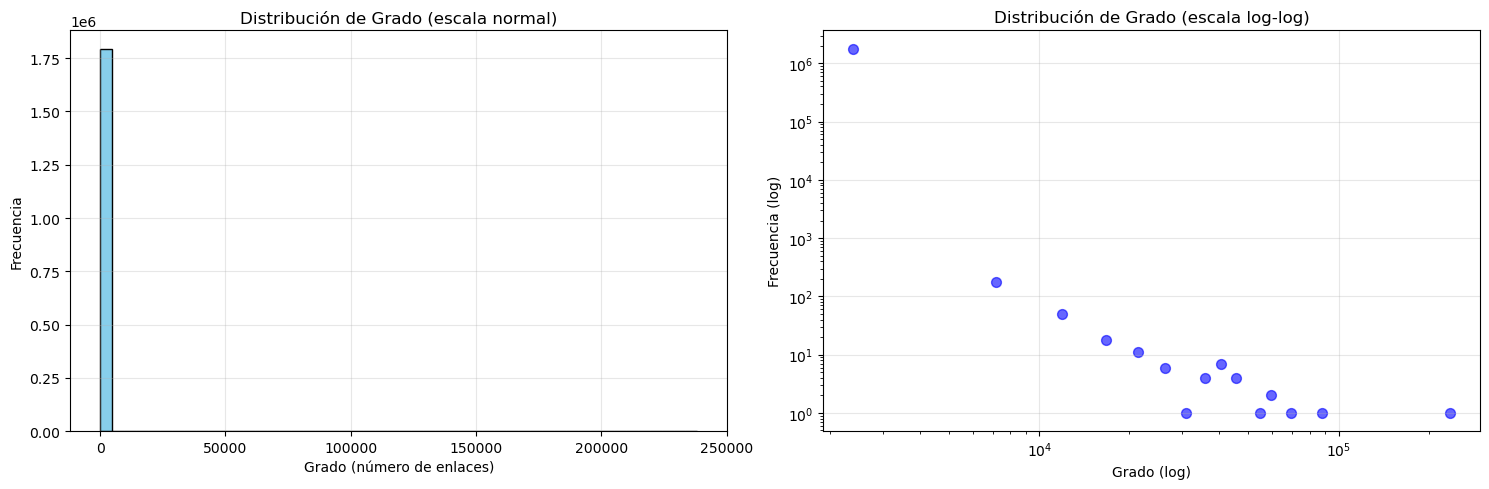

In [7]:
if 'G' not in globals() or G is None or G.number_of_nodes() == 0:
    print('Ejecuta la celda de carga de datos primero.')
else:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f'\n=== MÉTRICAS BÁSICAS (Dataset Completo) ===')
    print(f'Nodos: {n:,}')
    print(f'Aristas: {m:,}')
    
    # Grado
    degrees = [d for _, d in G.degree()]
    print(f'\n=== Estadísticas de Grado ===')
    print(f'Grado mínimo: {min(degrees):,}')
    print(f'Grado máximo: {max(degrees):,}')
    print(f'Grado promedio: {round(statistics.mean(degrees), 2)}')
    
    # Densidad
    print(f'\n=== Densidad ===')
    print(f'Densidad: {nx.density(G):.6f}')

    # Componentes
    print(f'\n=== Componentes Conectados ===')
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    print(f'Número de componentes: {len(comps)}')
    print(f'Tamaño de la componente gigante: {len(comps[0]):,}')
    print(f'Porcentaje en componente gigante: {len(comps[0])/n*100:.2f}%')

    # Visualización de distribución de grado
    print(f'\n=== Visualización: Distribución de Grado ===')
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histograma normal
        ax1.hist(degrees, bins=50, color='skyblue', edgecolor='black')
        ax1.set_title('Distribución de Grado (escala normal)')
        ax1.set_xlabel('Grado (número de enlaces)')
        ax1.set_ylabel('Frecuencia')
        ax1.grid(True, alpha=0.3)
        
        # Histograma log-log
        hist, bins = np.histogram(degrees, bins=50)
        centers = (bins[:-1] + bins[1:]) / 2
        mask = hist > 0
        ax2.scatter(centers[mask], hist[mask], color='blue', alpha=0.6, s=50)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_title('Distribución de Grado (escala log-log)')
        ax2.set_xlabel('Grado (log)')
        ax2.set_ylabel('Frecuencia (log)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Error en visualización: {e}')

# 3. Métodos de Detección de Comunidades

In [8]:
print("\n" + "="*70)
print("ANÁLISIS DETALLADO (MUESTRA)")
print("="*70)

# Verificar si existe la muestra
if 'G_muestra' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:
    print('\nG_muestra no esta disponible. Ejecuta primero:')
    print('  1. Carga de datos')
    print('  2. Muestreo estratificado')
    print('\nEste analisis se ejecutara automaticamente cuando G_muestra este lista.')
else:
    print('\nMuestra detectada. Ejecutando analisis detallado...\n')
    
    # Información de la muestra
    n_muestra = G_muestra.number_of_nodes()
    m_muestra = G_muestra.number_of_edges()
    print('Información de la Muestra:')
    print(f'  Nodos en muestra: {n_muestra:,}')
    print(f'  Aristas en muestra: {m_muestra:,}')
    
    # Clustering
    print('\nAnalisis de Clustering:')
    try:
        coef_clustering = nx.average_clustering(G_muestra)
        print(f'  Coeficiente de clustering promedio: {coef_clustering:.6f}')
        print('  Interpretacion: Mide que tan agrupados estan los nodos')
        print('    - 0 = sin agrupamiento local')
        print('    - 1 = maximo agrupamiento (todos conectados)')
    except Exception as e:
        print(f'  Error calculando clustering: {e}')
    
    # Triangulos
    print('\nAnalisis de Triangulos:')
    try:
        triangles = nx.triangles(G_muestra)
        num_triangles = sum(triangles.values()) // 3
        print(f'  Numero total de triangulos: {num_triangles:,}')
        print('  Interpretacion: Triangulos son 3 nodos mutuamente conectados')
    except Exception as e:
        print(f'  Error calculando triangulos: {e}')
    
    # Centralidades
    print('\nAnalisis de Centralidades:')
    
    # Centralidad de grado
    print('\n  Centralidad de Grado:')
    try:
        deg_cent = nx.degree_centrality(G_muestra)
        top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
        print('    Top 10 nodos por centralidad de grado:')
        for i, (node, val) in enumerate(top_deg, 1):
            print(f'      {i:2d}. Nodo {node}: {val:.6f}')
    except Exception as e:
        print(f'    Error: {e}')
    
    # Centralidad de intermediación (betweenness)
    print('\n  Centralidad de Intermediacion (Betweenness):')
    try:
        print('    Calculando (puede tomar tiempo)...')
        betweenness = nx.betweenness_centrality(G_muestra)
        top_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
        print('    Top 10 nodos (puentes importantes):')
        for i, (node, val) in enumerate(top_bet, 1):
            print(f'      {i:2d}. Nodo {node}: {val:.6f}')
        print('    Interpretacion: Nodos que actuan como puentes entre comunidades')
    except Exception as e:
        print(f'    Error: {e}')
    
    # Centralidad de cercania (closeness)
    print('\n  Centralidad de Cercania (Closeness):')
    try:
        print('    Calculando...')
        closeness = nx.closeness_centrality(G_muestra)
        top_close = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
        print('    Top 10 nodos mas cercanos al centro:')
        for i, (node, val) in enumerate(top_close, 1):
            print(f'      {i:2d}. Nodo {node}: {val:.6f}')
        print('    Interpretacion: Nodos que alcanzan rapidamente a otros nodos')
    except Exception as e:
        print(f'    Error: {e}')
    
    # Validacion de muestra
    print('\nValidacion de Representatividad de Muestra:')
    try:
        densidad_muestra = nx.density(G_muestra)
        densidad_original = nx.density(G)
        print(f'  Densidad - Muestra: {densidad_muestra:.6f}')
        print(f'  Densidad - Original: {densidad_original:.6f}')
        diff_relativa = abs(densidad_muestra - densidad_original) / densidad_original * 100
        print(f'  Diferencia relativa: {diff_relativa:.2f}%')
        if diff_relativa < 10:
            print('  Conclusion: La muestra representa bien el dataset original')
        else:
            print('  Conclusion: La muestra difiere moderadamente del dataset original')
    except Exception as e:
        print(f'  Error en validacion: {e}')


ANÁLISIS DETALLADO (MUESTRA)

Muestra detectada. Ejecutando analisis detallado...

Información de la Muestra:
  Nodos en muestra: 89,574
  Aristas en muestra: 1,608,850

Analisis de Clustering:
  Coeficiente de clustering promedio: 0.179163
  Interpretacion: Mide que tan agrupados estan los nodos
    - 0 = sin agrupamiento local
    - 1 = maximo agrupamiento (todos conectados)

Analisis de Triangulos:
  Numero total de triangulos: 5,888,484
  Interpretacion: Triangulos son 3 nodos mutuamente conectados

Analisis de Centralidades:

  Centralidad de Grado:
    Top 10 nodos por centralidad de grado:
       1. Nodo 279122: 0.151217
       2. Nodo 541013: 0.058544
       3. Nodo 121347: 0.053789
       4. Nodo 987583: 0.050194
       5. Nodo 230038: 0.045315
       6. Nodo 896828: 0.043908
       7. Nodo 98332: 0.043417
       8. Nodo 610154: 0.036741
       9. Nodo 362517: 0.033905
      10. Nodo 1118496: 0.030578

  Centralidad de Intermediacion (Betweenness):
    Calculando (puede tomar

KeyboardInterrupt: 

## 3.2 Detección de Comunidades (Muestra)

Los algoritmos de detección de comunidades se aplican a la muestra estratificada para identificar grupos de nodos altamente interconectados.

**Algoritmos implementados:**
* Louvain - Optimizacion de modularidad (rapido, recomendado)
* Label Propagation - Propagacion de etiquetas (muy rapido, sin hiperparametros)
* Girvan-Newman - Demo en subgrafo (para ilustracion de estructura jerarquica)

**Criterios de selección:**
- Louvain: Balance entre velocidad y calidad de resultados
- Label Propagation: Cuando necesitas rapidez extrema
- Girvan-Newman: Para entender la estructura jerarquica en grafos pequeños

**Nota:** En esta sección se implementan los algoritmos de detección en la muestra, se comparan resultados y se evalua el desempeño computacional.

In [ ]:
print("\n" + "="*70)
print("DETECCIÓN DE COMUNIDADES")
print("="*70)

# Verificar si existe la muestra
if 'G_muestra' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:
    print('\nG_muestra no esta disponible. Ejecuta primero:')
    print('  1. Carga de datos')
    print('  2. Muestreo estratificado')
    print('\nEste analisis se ejecutara automaticamente cuando G_muestra este lista.')
else:
    print('\nMuestra detectada. Ejecutando deteccion de comunidades...\n')
    
    partition = None
    
    # Algoritmo de Louvain
    print('Algoritmo de Louvain:')
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G_muestra)
        counts = Counter(partition.values())
        print(f'  Comunidades detectadas: {len(counts)}')
        print(f'  Top 5 comunidades por tamaño:')
        for i, (comm_id, count) in enumerate(counts.most_common(5), 1):
            print(f'    {i}. Comunidad {comm_id}: {count:,} nodos')
        print('  Louvain completado exitosamente')
    except ImportError:
        print('  Advertencia: python-louvain no instalado.')
        print('  Instalar con: pip install python-louvain')
        partition = None
    except Exception as e:
        print(f'  Error en Louvain: {e}')
        partition = None

    # Algoritmo de Label Propagation
    print('\nAlgoritmo de Label Propagation:')
    try:
        from networkx.algorithms.community import label_propagation
        lp_comms = list(label_propagation.label_propagation_communities(G_muestra))
        sizes_lp = [len(c) for c in lp_comms]
        print(f'  Comunidades detectadas: {len(lp_comms)}')
        print(f'  Tamaños: min={min(sizes_lp):,}, max={max(sizes_lp):,}, promedio={sum(sizes_lp)/len(sizes_lp):.0f}')
        print('  Label Propagation completado exitosamente')
    except Exception as e:
        print(f'  Error en Label Propagation: {e}')

    # Algoritmo de Girvan-Newman (Demo en subgrafo)
    print('\nAlgoritmo de Girvan-Newman (Demo):')
    try:
        from networkx.algorithms import community as nx_comm
        # Tomar los 500 nodos de mayor grado como demo
        nodes_top = list(sorted(G_muestra.nodes(), key=lambda n: G_muestra.degree(n), reverse=True))[:500]
        G_gn = G_muestra.subgraph(nodes_top).copy()
        comp_gen = nx_comm.girvan_newman(G_gn)
        top = tuple(sorted(c) for c in next(comp_gen))
        print(f'  Demo en subgrafo de {len(nodes_top)} nodos')
        print(f'  Comunidades en primer corte: {len(top)}')
        sizes_gn = [len(c) for c in top]
        print(f'  Tamaños: min={min(sizes_gn):,}, max={max(sizes_gn):,}')
        print('  Girvan-Newman demo completado')
    except Exception as e:
        print(f'  Error en Girvan-Newman: {e}')
    
    # Guardar partition para uso posterior
    if partition:
        print('\nParticion guardada como variable global "partition" para analisis posterior')


DETECCIÓN DE COMUNIDADES

G_muestra no esta disponible. Ejecuta primero:
  1. Carga de datos
  2. Muestreo estratificado

Este analisis se ejecutara automaticamente cuando G_muestra este lista.


# 4. Visualización de Comunidades

Técnicas efectivas para visualizar y comprender las estructuras comunitarias:

## 4.1 Técnicas de Visualización
* Layouts de fuerza dirigida
* Visualización jerárquica
* Mapas de calor
* Representaciones circulares

## 4.2 Estrategias de Diseño
* Codificación por colores
* Agrupamiento visual
* Escalado de nodos
* Filtrado interactivo

## 4.3 Interpretación Visual
* Patrones estructurales
* Roles de nodos
* Conexiones entre comunidades
* Anomalías y casos especiales

**Nota**: En esta sección implementaremos:
* Creación de visualizaciones
* Personalización de layouts
* Interactividad
* Exportación de gráficos

In [ ]:
print("\n" + "="*70)
print("VISUALIZACIÓN DE COMUNIDADES")
print("="*70)

if 'G_muestra' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:
    print('\nG_muestra no disponible. Ejecuta primero:')
    print('  1. Carga de datos')
    print('  2. Muestreo estratificado')
    print('  3. Deteccion de comunidades')
else:
    print('\nMuestra disponible. Visualizando comunidades...\n')
    
    try:
        # Verificar si existe partition del algoritmo de Louvain
        if 'partition' not in globals() or partition is None:
            print('Usando componentes conectadas como comunidades (fallback)')
            comm_map = {n: i for i, comp in enumerate(nx.connected_components(G_muestra)) for n in comp}
        else:
            print('Usando particion del algoritmo de Louvain')
            comm_map = partition
        
        # Usar muestra completa para visualizar
        nodes_viz = list(G_muestra.nodes())
        unique_comms = sorted({comm_map.get(n, 0) for n in nodes_viz})
        
        print(f'Numero de comunidades a visualizar: {len(unique_comms)}')
        
        # Crear mapa de colores
        cmap = plt.cm.get_cmap('tab20', max(1, len(unique_comms)))
        color_list = [cmap(unique_comms.index(comm_map.get(n, 0))) for n in nodes_viz]
        
        # Layout de fuerza dirigida
        print('Calculando layout de fuerza dirigida (puede tomar tiempo)...')
        pos = nx.spring_layout(G_muestra, seed=42, k=0.1, iterations=30, scale=1)
        
        # Visualización
        plt.figure(figsize=(14, 10))
        nx.draw_networkx_nodes(G_muestra, pos, node_size=30, node_color=color_list, alpha=0.8)
        nx.draw_networkx_edges(G_muestra, pos, alpha=0.1, width=0.3, edge_color='gray')
        plt.title('Muestra de Red - Coloreada por Comunidades', fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de comunidades
        print('\nEstadísticas de Comunidades:')
        size_by_comm = Counter(comm_map.get(n, 0) for n in nodes_viz)
        print(f'Total de comunidades: {len(size_by_comm)}')
        print(f'\nTop 10 comunidades por tamaño:')
        for i, (comm_id, count) in enumerate(size_by_comm.most_common(10), 1):
            print(f'  {i:2d}. Comunidad {comm_id}: {count:,} nodos ({count/len(nodes_viz)*100:.1f}%)')
        
    except Exception as e:
        print(f'Error en visualizacion: {e}')


VISUALIZACIÓN DE COMUNIDADES

G_muestra no disponible. Ejecuta primero:
  1. Carga de datos
  2. Muestreo estratificado
  3. Deteccion de comunidades


# 4. Visualización y Evaluación de Comunidades

## 4.1 Visualización de Comunidades

Tecnicas para visualizar y comprender la estructura de las comunidades:

* Layouts de fuerza dirigida (spring layout)
* Codificacion por colores segun comunidad
* Estadisticas de tamaño de comunidades
* Interpretacion visual de la estructura

**Procedimiento:**
1. Ejecutar deteccion de comunidades
2. Generar layout con fuerza dirigida
3. Colorear nodos segun comunidad detectada
4. Mostrar estadisticas de tamaño y distribucion

## 4.2 Evaluación de Calidad de Comunidades

Metricas internas y externas para evaluar la calidad de las comunidades detectadas:

**Metricas Internas:**
* Modularidad - Mide la calidad de la particion en comunidades
* Conductancia - Mide que tan aislada esta cada comunidad
* Densidad intra-comunidad - Densidad de enlaces dentro de comunidades

**Metricas Externas (requiere ground truth):**
* Indice de Rand Ajustado (ARI) - Compara particiones
* Información Mutua Normalizada (NMI) - Mide similitud entre particiones
* F-measure - Balance entre precision y recall

**Nota:** Las metricas se calculan automaticamente cuando hay datos disponibles.

In [ ]:
print("\n" + "="*70)
print("EVALUACIÓN DE CALIDAD DE COMUNIDADES")
print("="*70)

def conductance(G, community_nodes):
    """Calcula la conductancia de una comunidad (que tan bien esta separada)"""
    cut = 0
    volS = 0
    for u in community_nodes:
        volS += G.degree(u)
        for v in G.neighbors(u):
            if v not in community_nodes:
                cut += 1
    vol_rest = sum(dict(G.degree()).values()) - volS
    denom = min(volS, vol_rest) if min(volS, vol_rest) > 0 else 1
    return cut / denom

if 'G_muestra' not in globals() or G_muestra is None or G_muestra.number_of_nodes() == 0:
    print('\nG_muestra no disponible.')
    print('Ejecuta primero: 1) Carga, 2) Muestreo, 3) Deteccion de comunidades')
elif 'partition' not in globals() or partition is None:
    print('\nParticion de comunidades no disponible.')
    print('Ejecuta primero la celda de deteccion de comunidades (Louvain)')
else:
    print('\nEvaluando calidad de comunidades detectadas...\n')
    
    try:
        # Modularidad
        print('Modularidad (Louvain):')
        try:
            import community as community_louvain
            mod = community_louvain.modularity(partition, G_muestra)
            print(f'  Valor: {mod:.6f}')
            print('  Interpretacion:')
            if mod > 0.4:
                print('    Excelente - Comunidades muy bien definidas')
            elif mod > 0.3:
                print('    Buena - Comunidades bien separadas')
            elif mod > 0.1:
                print('    Moderada - Algunas comunidades identificadas')
            else:
                print('    Baja - Comunidades poco definidas')
        except Exception as e:
            print(f'  Error: {e}')
        
        # Conductancia
        print('\nConductancia de Comunidades:')
        print('  Metrica que mide que tan aislada esta cada comunidad')
        print('  (Valores mas bajos = mejor separacion)\n')
        try:
            comms = defaultdict(list)
            for n, c in partition.items():
                comms[c].append(n)
            
            conductances = []
            top = sorted(comms.items(), key=lambda x: len(x[1]), reverse=True)[:5]
            
            print('  Top 5 comunidades mas grandes:')
            for i, (cid, nodes) in enumerate(top, 1):
                cond = conductance(G_muestra, set(nodes))
                conductances.append(cond)
                print(f'    {i}. Comunidad {cid}: {len(nodes):5} nodos, Conductancia: {cond:.6f}')
            
            print(f'\n  Conductancia promedio (top 5): {sum(conductances)/len(conductances):.6f}')
        except Exception as e:
            print(f'  Error: {e}')
        
        # Metricas externas (si hay ground truth)
        print('\nMetricas Externas (Comparacion con Ground Truth):')
        try:
            from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
            if 'true_labels' in globals() and true_labels:
                nodes_common = [n for n in G_muestra.nodes() if n in true_labels and n in partition]
                if nodes_common:
                    y_true = [true_labels[n] for n in nodes_common]
                    y_pred = [partition[n] for n in nodes_common]
                    nmi = normalized_mutual_info_score(y_true, y_pred)
                    ari = adjusted_rand_score(y_true, y_pred)
                    print(f'  NMI (Información Mutua Normalizada): {nmi:.6f}')
                    print(f'  ARI (Índice de Rand Ajustado): {ari:.6f}')
                    print('  (Valores cercanos a 1 = mejor concordancia con ground truth)')
                else:
                    print('  No hay nodos comunes en true_labels y partition')
            else:
                print('  Ground truth (true_labels) no disponible')
        except ImportError:
            print('  sklearn no instalado. Para metricas externas: pip install scikit-learn')
        except Exception as e:
            print(f'  Error en metricas externas: {e}')
    
    except Exception as e:
        print(f'Error general en evaluacion: {e}')


EVALUACIÓN DE CALIDAD DE COMUNIDADES

G_muestra no disponible.
Ejecuta primero: 1) Carga, 2) Muestreo, 3) Deteccion de comunidades


## 6.1 Dinámica de Comunidades
* Nacimiento y muerte
* Fusión y división
* Crecimiento y contracción
* Estabilidad y cambio

## 6.2 Métricas Temporales
* Supervivencia de comunidades
* Tasa de cambio
* Persistencia de membresía
* Evolución estructural

## 6.3 Patrones de Evolución
* Ciclos de vida
* Puntos de transición
* Factores de cambio
* Predicción de evolución

**Nota**: En esta sección implementaremos:
* Análisis de series temporales
* Tracking de comunidades
* Visualización de evolución
* Predicción de cambios

---

## Conclusión
Este notebook servirá como guía para el análisis de comunidades en redes, con implementaciones prácticas, ejemplos y visualizaciones.

In [ ]:
def slice_windows(path, window_size=86400, max_lines=None):
    windows = defaultdict(list)
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if max_lines and i>=max_lines: break
            parts = line.strip().split()
            if len(parts) < 3:
                if len(parts) >= 2:
                    windows[0].append((parts[0], parts[1]))
                continue
            try:
                t = int(parts[2])
            except:
                continue
            win = (t//window_size)*window_size
            windows[win].append((parts[0], parts[1]))
    return windows

print('Si tu edgelist incluye timestamps, usa slice_windows para crear snapshots por ventana.')

Si tu edgelist incluye timestamps, usa slice_windows para crear snapshots por ventana.
